# Import

In [ ]:
print("start")

In [ ]:
# !pip install pytorch_lightning

In [ ]:
# !pip install tensorboard

In [21]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import os
from PIL import Image
import pickle
import pytorch_lightning as pl
import timm
import wandb
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime

# Task: Human face to anime

### Approaches:
* AE that contains only CNN layers
* AE that contains dense layers after and before CNNs.
* same as above but implement VAE

#### Advanced ideas
* U net architicture - https://www.geeksforgeeks.org/u-net-architecture-explained/
* feature extractor from timm

#### Todo:
1. remove freezing the encoder
1. change decoder architicture and sigmoid function
2. find other pretrained model that is more suitable to the data, maybe human face auto encoder or maybe human face classifier.
3. use LPIPS at the auto encoder loss function
4. convert the model to VAE

## Download Human face Data

In [ ]:
# import kagglehub

# # # Download latest version
# path = kagglehub.dataset_download("ashwingupta3012/human-faces")
# data_path = '/kaggle/input/human-faces/Humans'
# print("Path to dataset files:", path)

# !mv /kaggle/input/ffhq-128-70k/ ./

In [2]:
data_path = '/kaggle/input/human-faces/Humans'
data_path = "/kaggle/input/ffhq-128-70k"
# data_path = '/content/1/Humans'

## testing models shapes


In [ ]:
# im_path = "/kaggle/input/human-faces/Humans/1 (96).png"
# im_path = '/kaggle/input/human-faces/Humans/1 (1684).jpg'

# image = Image.open(im_path)
# print(transforms.ToTensor()(image).shape)
# plt.imshow(image)
# plt.show()

# transform = transforms.Compose([
#     transforms.Resize((512,512)),
#     transforms.ToTensor()
# ])

# image = transform(image)
# if image.shape[0] == 4:
#     image = image[:-1,:,:]
# image = image.unsqueeze(0)
# # print(image.unsqueeze(0).shape)

# convs = [3, 32, 64, 128]
# m_convVEncoder = convEncoder(convs)
# m_convVDecoder = convDecoder(convs)

# # Print the model architecture
# enc = m_convVEncoder(image)
# dec = m_convVDecoder(enc)

# print(image.shape)
# print(enc.shape)
# print(dec.shape)
# #.transpose(1, 2, 0)
# plt.imshow(dec.detach().squeeze().numpy().transpose(1, 2, 0))
# # plt.imshow(dec.detach().squeeze().numpy())
# plt.show()


## Get valid images paths

### Load pickle file faster, (if exist)

In [ ]:
data_path

In [ ]:
# load from pickle
# human_images_paths = pickle.load(open('human_images_paths.pkl', 'rb'))
# data_path = '/kaggle/input/human-faces/Humans'


pickle_file_path = '/content/human_images_paths.pkl'
pickle_file_path = '/kaggle/input/human-images-paths/human_images_paths.pkl'

# data_path = '/content/1/Humans'
human_images_paths = pickle.load(open(pickle_file_path, 'rb'))

### Loop: image channel counts: (array([1, 3, 4]), array([ 160, 6980,   79]))

In [ ]:
# stats about the data files

# print(f"total of {len(os.listdir(data_path))} images")
# sizes = []

# im_transform = transforms.Compose([
#     transforms.Resize((512,512)),
#     transforms.ToTensor()
# ])

# c = 0
# human_images_paths = []
# for img in os.listdir(data_path):
#     image = Image.open(data_path + img)
#     im_tensor = im_transform(image)
#     if im_tensor.shape[0] != 3 and im_tensor.shape[0] != 4:
#         continue

#     # keep only RGB images
#     human_images_paths.append(data_path + img)
#     # print(human_images_paths[-1])

#     if c < 5:
#         plt.imshow(image)
#         plt.show()

#     c+= 1



# print(np.unique(sizes, return_counts=True))

# # save paths as pickle object
# with open('human_images_paths.pkl', 'wb') as f:
#     pickle.dump(human_images_paths, f)

## Build dataset class

### Original Data (without augmentation)

In [34]:
from logging import setLogRecordFactory

class HumanFaceDataset(Dataset):
    def __init__(self, data_path = None, transform=None, images_paths_list = None, kaggle=False):
        self.data_path = data_path # the folder that directly contains all the images
        self.transform = transform
        self.kaggle_env = kaggle
        
        self.includes_path = images_paths_list is not None
        if images_paths_list is not None or len(images_paths_list) != 0:
            self.images = np.array(images_paths_list)
        else:
            self.images = np.array(os.listdir(data_path))


    def split_dataset(self, split_ratio=0.8, val_transform=None):
        # train_size = int(split_ratio * len(self))  # 80% for training
        # val_size = len(self) - train_size  # Remaining 20% for validation

        # # Randomly split the dataset
        # train_dataset, val_dataset = random_split(self, [train_size, val_size])
        # val_dataset.transform = val_transform
        
        # return train_dataset, val_dataset


        train_size = int(split_ratio * len(self))  # 80% for training
        val_size = len(self) - train_size  # Remaining 20% for validation

        # Randomly split the dataset
        train_indices, val_indices = torch.utils.data.random_split(
            range(len(self)), [train_size, val_size]
        )

        train_indices = np.array(train_indices.indices, dtype=int)
        val_indices = np.array(val_indices.indices, dtype=int)

        train_dataset = HumanFaceDataset(self.data_path, transform=self.transform, images_paths_list=self.images[train_indices], kaggle=True)
        val_dataset = HumanFaceDataset(self.data_path, transform=val_transform, images_paths_list=self.images[val_indices], kaggle=True)

        return train_dataset, val_dataset
    
        


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.data_path + self.images[idx] if not self.includes_path else self.images[idx]
        if self.kaggle_env:
            img_path = f"{self.data_path}/{self.images[idx].split('/')[-1]}"
        
        # print(img_path)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        if image.shape[0] == 4:
            image = image[:-1,:,:]
        # print(image.shape)
        # if image.shape[0] != 3:
        #   # print(self.data_path + self.images[idx])
        if image.dtype == torch.uint8:
            return image.float() / 255
        else:
            if (image > 1).any():
                image /= 255

        # print(f"wierd image dtype found {img_path}, {image.dtype}")
        return image

### Augmentation Dataset

In [14]:
class AugmentationHumanFaceDataset(Dataset):
  def __init__(self, data_path = None, transform=None, images_paths_list = None, augmentaions = []):
    """
    data_path: the folder that directly contains all the images
    transform: torchvision transform object that is applied to all images if not None
    images_paths_list: a list of filtered images paths,  if None then read all images in data_path
    augmentaions: a list of callables that are applied to all images, each augmentation is done separately on each image
    """
    self.data_path = data_path # the folder that directly contains all the images
    self.transform = transform

    self.includes_path = images_paths_list is not None
    self.augmentaions = augmentaions

    if images_paths_list:
      self.images = images_paths_list
    else:
      self.images = os.listdir(data_path)

  def __len__(self):
    return len(self.images) * len(self.augmentaions) # we produce  x versions of each  image (where x is len(self.augmentaions)

  def __getitem__(self, idx):
    """ remember we produce the augmented images in real time,
    for example: index 0 is image 0 with self.augmentation[0],
                 index 1 is image 0 with self.augmentation[1],
                 index 2 is image 0 with self.augmentation[2],
                 index 3 is image 1 with self.augmentation[0],
                 and so on ... indices depends on len(self.augmentaions)

    """
    folder_idx = idx // len(self.augmentaions)
    img_path = self.data_path + self.images[folder_idx] if not self.includes_path else self.images[folder_idx]
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)


    if image.shape[0] == 4:
      image = image[:-1,:,:]

    if image.dtype == torch.uint8:
      image =  image.float() / 255
    else:
      print(f"\n\nwierd image dtype found {img_path}, {image.dtype}\n\n")

      if (image > 1).any():
        image = image / 255

    augmentation_idx = idx % len(self.augmentaions)
    aug_image = self.augmentaions[augmentation_idx](image)
    # print(image.shape)
    # if image.shape[0] != 3:
    #   # print(self.data_path + self.images[idx])
    return image

# Integrate pretrained models

## Model: regnety_016.pycls_in1k

In [ ]:
# regnety = timm.create_model('regnety_016.pycls_in1k', pretrained=True)


# regnety


## Build AE Model class

In [ ]:
# regnety.forward_features

In [5]:
class convDecoder(nn.Module): # BL = Bottle Neck
    def __init__(self, convs, act_fn = None):
        super(convDecoder, self).__init__()
        act_fn = nn.ReLU()
        self.layers = nn.Sequential()
        self.layers.append(nn.BatchNorm2d(convs[-1]))
        for i in range(len(convs)-1, 0, -1):
            # print(convs[i])

            self.layers.append(
                    nn.Conv2d(convs[i], convs[i - 1], kernel_size=3, padding=1))

            # self.layers.append(act_fn)

            self.layers.append(
                    nn.ConvTranspose2d(convs[i - 1], convs[i - 1], kernel_size=3, stride=2, padding=1, output_padding=1))

            if i > 1:
              self.layers.append(act_fn)
              # self.layers.append(nn.BatchNorm2d(convs[i - 1]))

        self.layers.append(nn.Sigmoid())



    def forward(self, x):
        x = self.layers(x)
        return x


# class regnety16AE(pl.LightningModule):
#     def __init__(self, convs = [3, 64, 111, 222, 444, 888], loss_fn = nn.MSELoss(), learning_rate = 0.001):
#         super(regnety16AE, self).__init__()

#         self.encoder = timm.create_model('regnety_016.pycls_in1k', pretrained=True)
#         for param in self.encoder.parameters():
#             param.requires_grad = False

#         self.decoder = convDecoder(convs)
#         self.loss_fn = loss_fn
#         self.learning_rate = learning_rate

#     def forward(self, x):
#         features = self.encoder.forward_features(x)
#         # pool = self.encoder.head.global_pool(features)
#         recon = self.decoder(features)
#         return recon

#     def training_step(self, batch, batch_idx):
#         data = batch.to(self.device).float()
#         x_recon = self(data)
#         loss = self.loss_fn(x_recon, data)

#         # Log training loss
#         self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
#         return loss


#     def validation_step(self, batch, batch_idx):
#         data = batch.to(self.device).float()
#         x_recon = self(data)
#         loss = self.loss_fn(x_recon, data)
#         self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         return loss


#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
#         scheduler = {
#             'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
#             'monitor': 'val_loss',  # Monitor validation loss
#             'interval': 'epoch',
#             'frequency': 1,
#         }
#         return [optimizer], [scheduler]





# Initialize the model


In [6]:

class regnety16AE(pl.LightningModule):
    def __init__(self, convs=[3, 64, 111, 222, 444, 888], loss_fn=nn.MSELoss(), learning_rate=0.001, trans=None):
        super(regnety16AE, self).__init__()

        self.encoder = timm.create_model('regnety_016.pycls_in1k', pretrained=True)
        # for param in self.encoder.parameters():
        #     param.requires_grad = False

        self.decoder = convDecoder(convs)
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate

        # Paths for reconstruction logging
        self.reconstruction_files = [
            "/kaggle/input/ffhq-128-70k/1.png",
            "/kaggle/input/ffhq-128-70k/10004.png",
            "/kaggle/input/ffhq-128-70k/10010.png",
            "/kaggle/input/ffhq-128-70k/10012.png"
        ]
        transform=trans
        self.reconstruction_images = [
            transform(Image.open(img).convert('RGB')).unsqueeze(0) for img in self.reconstruction_files
        ]

    def forward(self, x):
        features = self.encoder.forward_features(x)
        recon = self.decoder(features)
        return recon

    def training_step(self, batch, batch_idx):
        data = batch.to(self.device).float()
        x_recon = self(data)
        loss = self.loss_fn(x_recon, data)

        # Log training loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data = batch.to(self.device).float()
        x_recon = self(data)
        loss = self.loss_fn(x_recon, data)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_epoch_end(self):
        # Call log_reconstructions every 20 epochs
        if (self.current_epoch + 1) % 10 == 0:  # +1 because current_epoch is zero-indexed
            self.log_reconstructions()

    def log_reconstructions(self):
        self.eval()
        with torch.no_grad():
            reconstructions = []
            for img_tensor in self.reconstruction_images:
                img_tensor = img_tensor.to(self.device)
                reconstructed = self(img_tensor).cpu()
                reconstructions.append(reconstructed)
            
            for idx, img in enumerate(reconstructions):
                save_image(img, f"reconstruction_{idx}.png", normalize=True)
                # Log to W&B
                self.logger.experiment.log({
                    f"reconstruction_{idx}": wandb.Image(f"reconstruction_{idx}.png")
                })

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',  # Monitor validation loss
            'interval': 'epoch',
            'frequency': 1,
        }
        return [optimizer], [scheduler]

In [7]:
# regnety16AE()
print("Model Class Defined")

Model Class Defined


In [ ]:
print("testing input and output shapes")

transform = transforms.Compose([
            transforms.Resize((128, 128)),  # Ensure all images are 128x128
            transforms.ToTensor()])


convs = [3, 64, 111, 222, 444, 888]
model = regnety16AE(convs, trans=transform)

model.eval()
with torch.no_grad():
  sample = torch.rand((1, 3,128,128))

  out = model(sample)

print("done", out.shape)
# out.shape

In [8]:
model = torch.load("/kaggle/input/hp_v4/pytorch/default/1/model_2025-01-18 04_27_49.096532.pth")
# model

<ipython-input-8-c1cabed6aed4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/hp_v4/pytorch/default/1/model_2025-01-18 04_27_49.096532.pt

In [15]:
from datetime import datetime

datetime.now()



datetime.datetime(2025, 1, 18, 10, 51, 49, 869710)

In [ ]:
transform

In [36]:


train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure all images are 128x128
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.3)),  # Low effect blur
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.ToTensor()  # Convert to tensor
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((128, 128))  # Ensure all images are 128x128
    
])


print("loading dataset")
train_dataset, val_dataset = HumanFaceDataset(data_path, transform=train_transform, images_paths_list=np.array(os.listdir(data_path)), kaggle=True).split_dataset(val_transform=val_transform)
print("done")


times = 1 # when using good gpu -> larger batch size -> larger learning rate (linearly with batch size) -> multiply these with times
batch_size = 128 * times
learning_rate = 0.001 * (times/1)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


wandb.login(key="a76b137600073d23f748b4c95961e31f6cceb6d2")

wandb_logger = WandbLogger(project="Human AE", name="regnety16AE" + str(datetime.now()))

config = {
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "model": "regnety16AE",
    "epochs": 100,
    "conv_layers": [3, 64, 111, 222, 444, 888],
    # Add other hyperparameters or configurations here
}


convs = [3, 64, 111, 222, 444, 888]
model = regnety16AE(convs, learning_rate=learning_rate, trans=val_transform)

trainer = pl.Trainer(
    max_epochs=20,  # Adjust as needed
    devices='auto',
    precision='16-mixed',
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=wandb_logger,
    log_every_n_steps=1
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

torch.save(model, f"model_{str(datetime.now())}.pth")

loading dataset
done


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ayal (ayal-israel). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/lightning_logs/

5

In [9]:
def reconstruct_image(model, im_path = "/kaggle/input/ffhq-128-70k/1.png", input_image_size=(64,64)):
    # im_path = "./1/Humans/1 (96).png"
    # im_path = '/content/1/Humans/1 (1684).jpg'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image = Image.open(im_path)
    print(transforms.ToTensor()(image).shape)
    plt.imshow(image)
    plt.title("Original")
    plt.show()

    # transform = transforms.Compose([
    #     transforms.Resize(input_image_size),
    #     transforms.ToTensor()
    # ])

    image = transform(image)
    if image.shape[0] == 4:
        image = image[:-1,:,:]

    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("input")
    plt.show()

    image = image.unsqueeze(0)
    # print(image)
    model.eval()
    with torch.no_grad():
      model.to(device)
      dec = model(image.to(device).float())
      print("MSE: ", nn.MSELoss()(dec.detach().cpu(), image))

    plt.imshow(dec.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title("model reconstruction")
    plt.show()

def recon_images(model, imgs = ["/kaggle/input/ffhq-128-70k/1.png", "/kaggle/input/ffhq-128-70k/10004.png", "/kaggle/input/ffhq-128-70k/10010.png", "/kaggle/input/ffhq-128-70k/10012.png"], kaggle=False):
    for img in imgs:
        if kaggle:
            img = f"{data_path}/{img.split('/')[-1]}"
        reconstruct_image(model, img)


In [ ]:
# model = torch.load("/kaggle/input/hp_v2/pytorch/default/1/model.pth")

### hp_v5: no freezing, normal batch size , added augmentations: train_loss_step=0.00355, val_loss=0.00348, train_loss_epoch=0.00336

torch.Size([3, 128, 128])


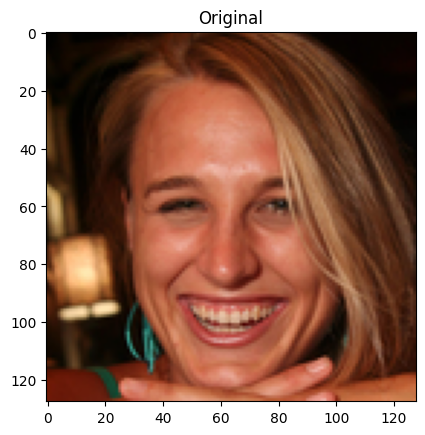

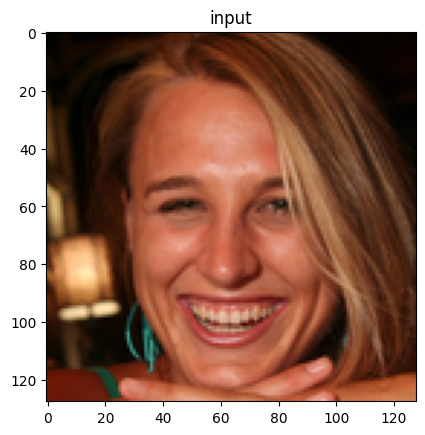

MSE:  tensor(0.0030)


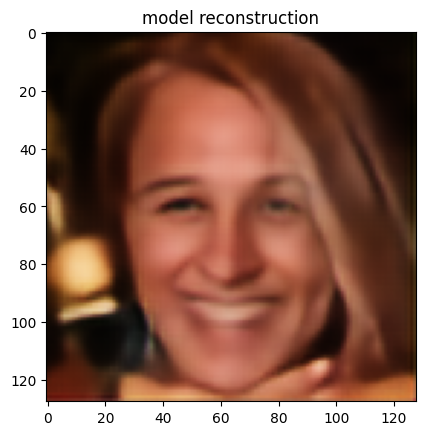

torch.Size([3, 128, 128])


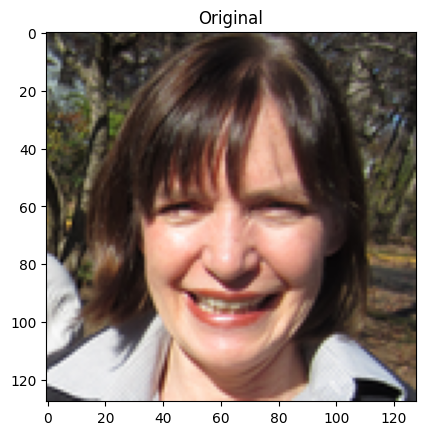

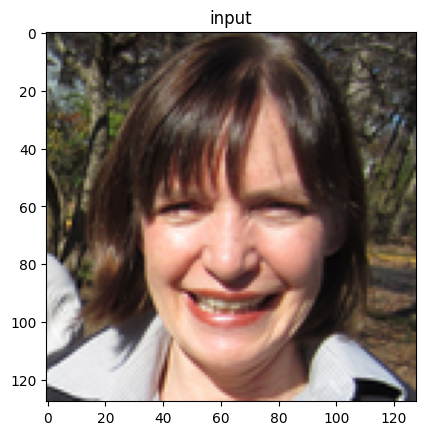

MSE:  tensor(0.0051)


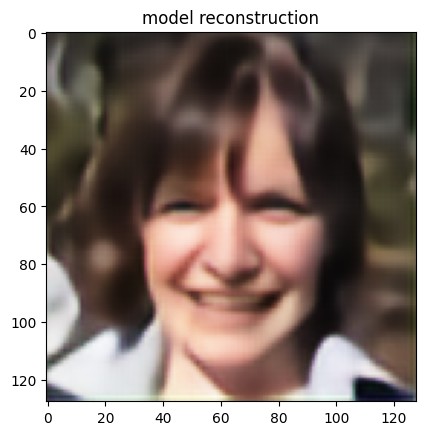

torch.Size([3, 128, 128])


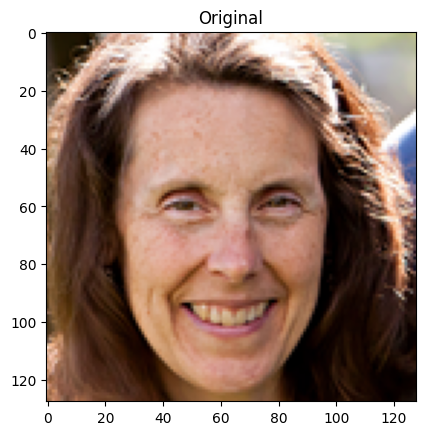

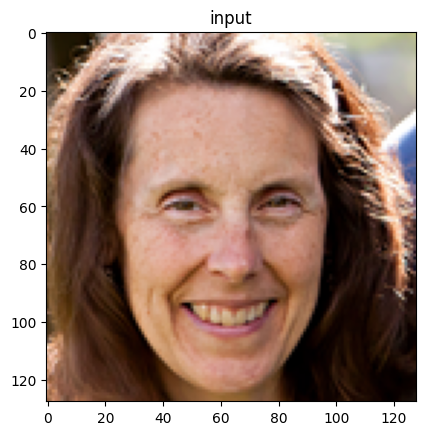

MSE:  tensor(0.0052)


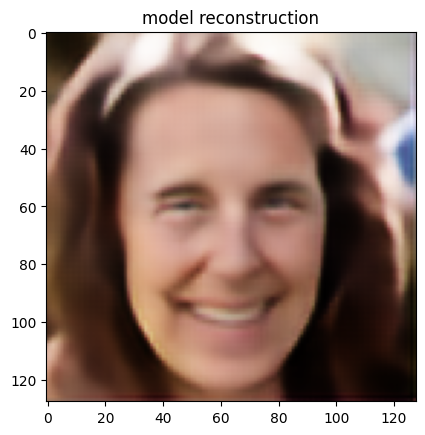

torch.Size([3, 128, 128])


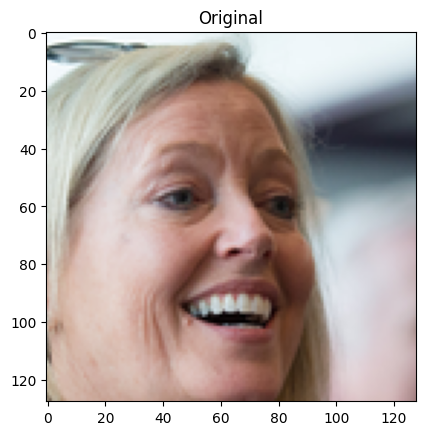

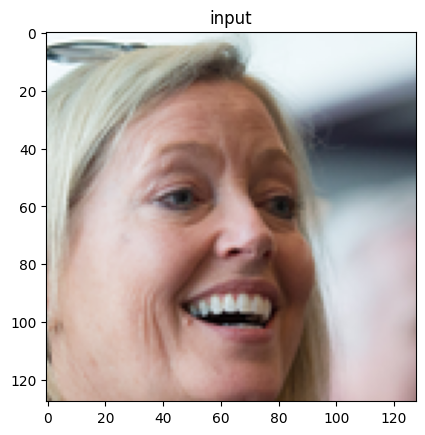

MSE:  tensor(0.0020)


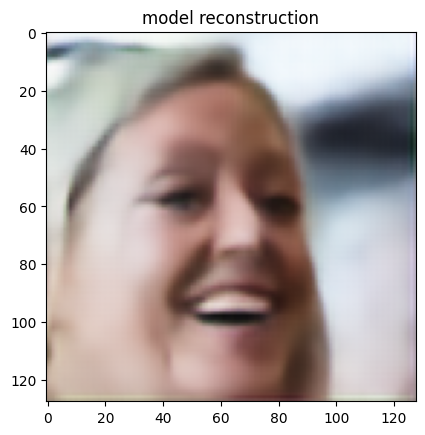

torch.Size([3, 367, 352])


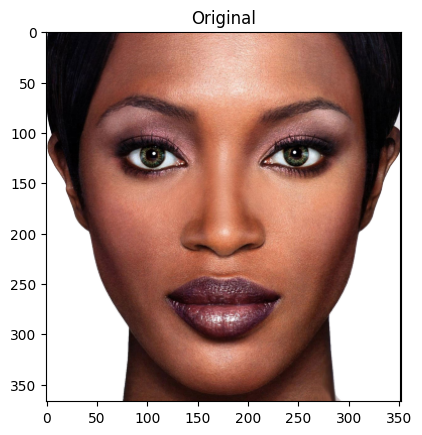

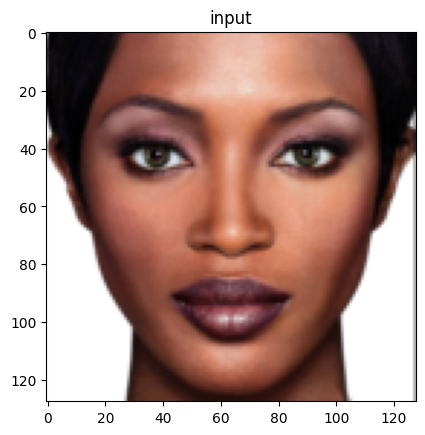

MSE:  tensor(0.0027)


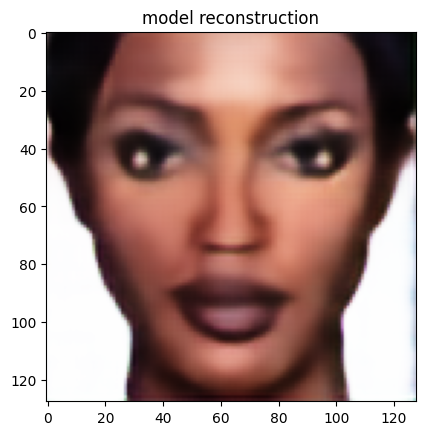

torch.Size([3, 236, 230])


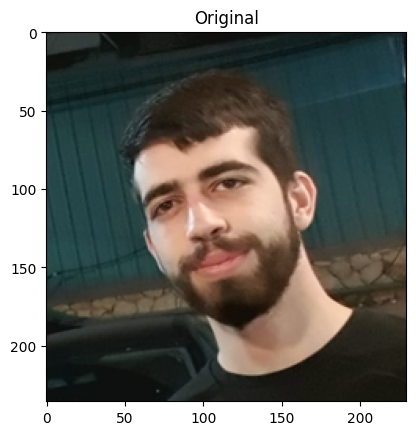

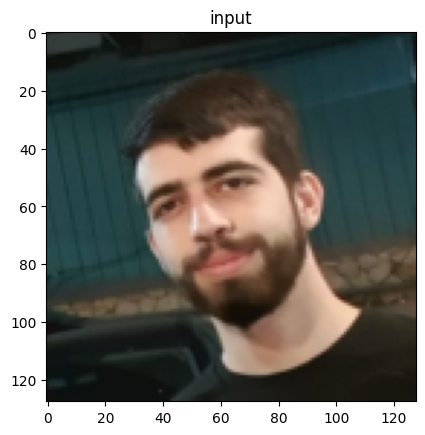

MSE:  tensor(0.0018)


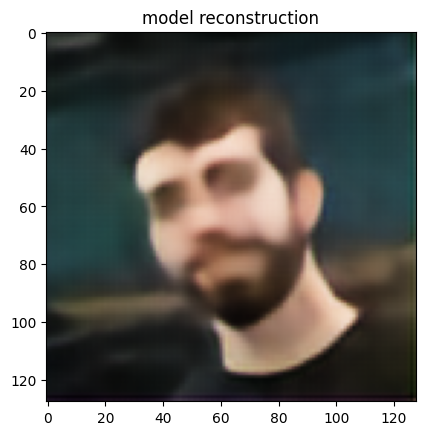

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # Convert to tensor
])

recon_images(model)
reconstruct_image(model, "/kaggle/input/l2dasdas/l2.png")
reconstruct_image(model, "/kaggle/input/my-pic/my_pic.png")

In [38]:
torch.save(model.state_dict(), "hp_v5_params.pth")

In [ ]:
reconstruct_image(model, "/kaggle/input/l2dasdas/l2.png")

### large batches, 1 epoch:

In [ ]:
# recon_images(model)

#### lrage batches, 10 epochs

In [ ]:
# recon_images(model)

#### hp_v2: 100 epochs: train_loss_step=0.016, train_loss_epoch=0.016, val_loss0.029

In [ ]:
# recon_images(model)

In [ ]:
# reconstruct_image(model, "/kaggle/input/my-pic/my_pic.png")

In [ ]:
# reconstruct_image(model, "/kaggle/input/l2dasdas/l2.png")

### hp_v2 - changed decoder architicture, added scheduler


####  hp_v2: 3 epochs:  train_loss_step=0.0443, val_loss=0.0402, train_loss_epoch=0.0452

In [ ]:
# recon_images(model)

####  hp_v1: 25 epochs:  train_loss_step=0.0091, val_loss=0.018, train_loss_epoch=0.0087

In [ ]:
# recon_images(model)

### hp_v2: 50 epochs: train_loss_step=0.00536, val_loss=0.00883, train_loss_epoch=0.0049

In [ ]:
# recon_images(model, kaggle=True)

In [ ]:
# recon_images(model, [human_images_paths[120], human_images_paths[1233], human_images_paths[5000]],kaggle=True)

### hp_v1: train_loss_step=0.0765, train_loss_epoch=0.0841

In [ ]:
# reconstruct_image(model)

In [ ]:
# reconstruct_image(model, "/content/1/Humans/1 (1015).jpg") # trained on the whole data

In [ ]:
# reconstruct_image(model, "/content/1/Humans/1 (1064).jpg")